In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import seaborn as sns

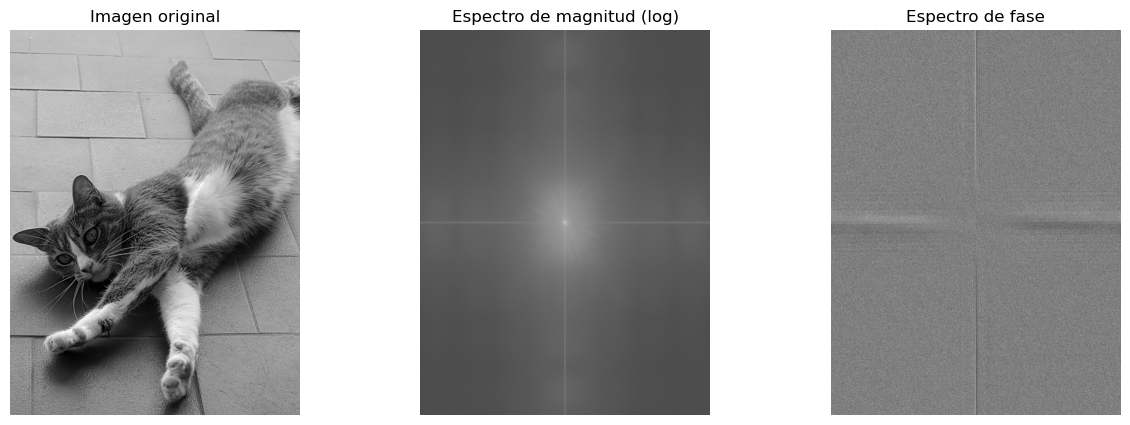

In [2]:
# 1. Cargar imagen en escala de grises
img = Image.open("ciripiso.jpg").convert("L")  # "L" = grayscale
img_array = np.array(img)

# 2. FFT 2D
fft2 = np.fft.fft2(img_array)
fft2_shifted = np.fft.fftshift(fft2)  # centramos el espectro

# 3. Magnitud y fase
magnitude = np.abs(fft2_shifted)
phase = np.angle(fft2_shifted)

# 4. Mostrar resultados
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img_array, cmap="gray")
plt.title("Imagen original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(np.log1p(magnitude), cmap="gray")
plt.title("Espectro de magnitud (log)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(phase, cmap="gray")
plt.title("Espectro de fase")
plt.axis("off");

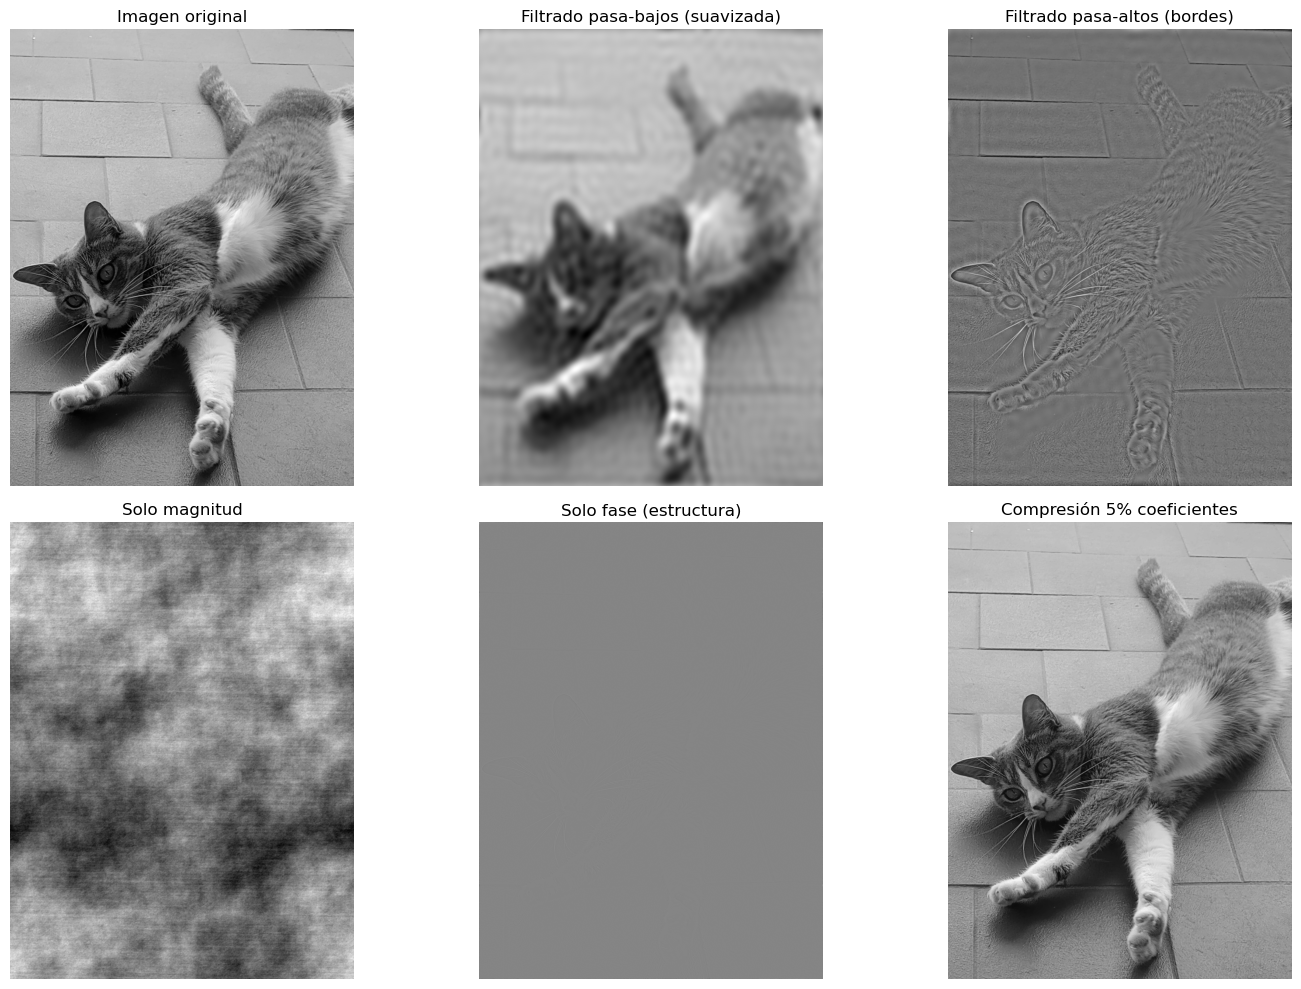

In [3]:
# ======================
# 2. Filtrado pasa-bajos
# ======================
rows, cols = img_array.shape
crow, ccol = rows//2, cols//2
mask_low = np.zeros_like(img_array)
r = 30  # radio del filtro
y, x = np.ogrid[:rows, :cols]
mask_area = (x - ccol)**2 + (y - crow)**2 <= r*r
mask_low[mask_area] = 1

low_pass = fft2_shifted * mask_low
img_low = np.fft.ifft2(np.fft.ifftshift(low_pass)).real

# ======================
# 3. Filtrado pasa-altos
# ======================
mask_high = 1 - mask_low
high_pass = fft2_shifted * mask_high
img_high = np.fft.ifft2(np.fft.ifftshift(high_pass)).real

# ======================
# 4. Magnitud vs fase
# ======================
# Usar magnitud de original y fase de ruido uniforme
random_phase = np.exp(1j * np.random.uniform(0, 2*np.pi, img_array.shape))
img_only_mag = np.fft.ifft2(np.fft.ifftshift(magnitude * random_phase)).real

# Usar fase real y magnitud constante
img_only_phase = np.fft.ifft2(np.fft.ifftshift(np.ones_like(magnitude) * np.exp(1j*phase))).real

# ======================
# 5. Compresión: quedarnos con el top 5% de coeficientes
# ======================
flat = magnitude.flatten()
threshold = np.percentile(flat, 95)  # top 5%
mask_compress = magnitude >= threshold
fft_compress = fft2_shifted * mask_compress
img_compress = np.fft.ifft2(np.fft.ifftshift(fft_compress)).real

# ======================
# 6. Graficar resultados
# ======================
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.imshow(img_array, cmap="gray")
plt.title("Imagen original")
plt.axis("off")

plt.subplot(2,3,2)
plt.imshow(img_low, cmap="gray")
plt.title("Filtrado pasa-bajos (suavizada)")
plt.axis("off")

plt.subplot(2,3,3)
plt.imshow(img_high, cmap="gray")
plt.title("Filtrado pasa-altos (bordes)")
plt.axis("off")

plt.subplot(2,3,4)
plt.imshow(img_only_mag, cmap="gray")
plt.title("Solo magnitud")
plt.axis("off")

plt.subplot(2,3,5)
plt.imshow(img_only_phase, cmap="gray")
plt.title("Solo fase (estructura)")
plt.axis("off")

plt.subplot(2,3,6)
plt.imshow(img_compress, cmap="gray")
plt.title("Compresión 5% coeficientes")
plt.axis("off")

plt.tight_layout()
plt.show()

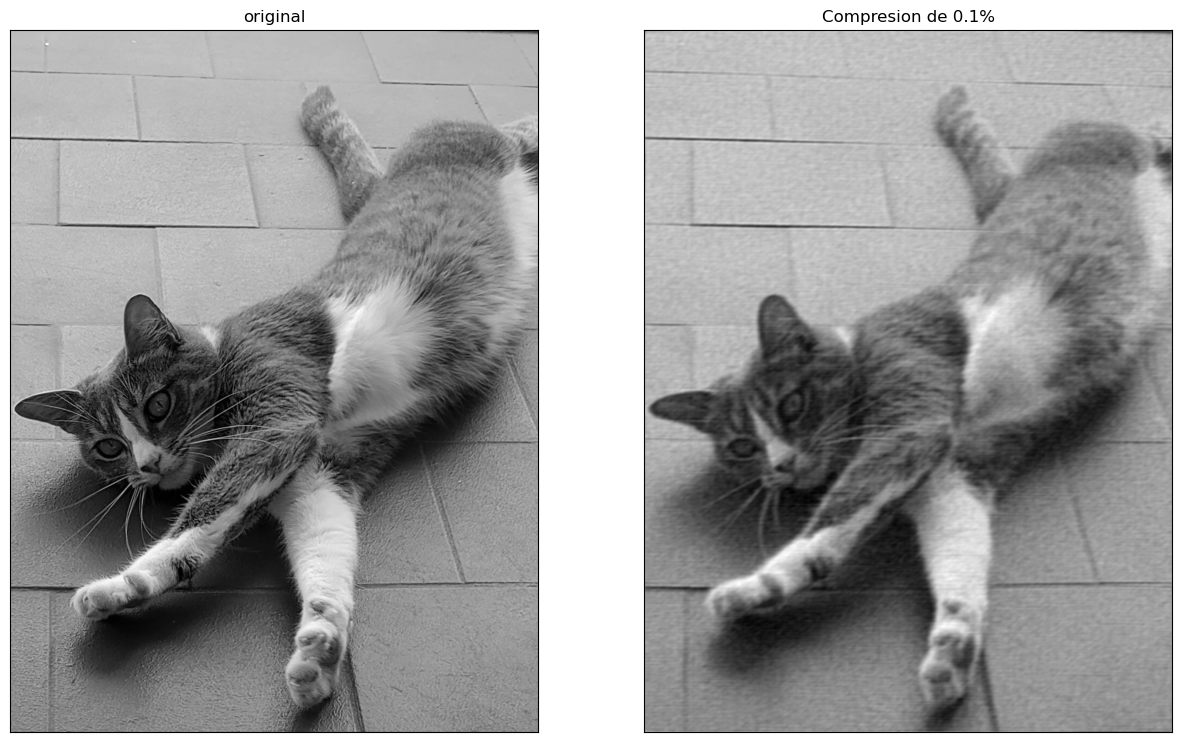

In [12]:
# ======================
# 5. Compresión: quedarnos con el top n% de coeficientes
# ======================
porcentaje = 0.1
flat = magnitude.flatten()
threshold = np.percentile(flat, 100 - porcentaje)
mask_compress = magnitude >= threshold
fft_compress = fft2_shifted * mask_compress
img_compress = np.fft.ifft2(np.fft.ifftshift(fft_compress)).real

_, ax = plt.subplots(1, 2, figsize=(15, 10))

ax[0].imshow(img_array, cmap="grey")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title("original")

ax[1].imshow(img_compress, cmap="grey")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title(f"Compresion de {porcentaje}%");

Graficar el MSE para ver que tanto se perdio

In [13]:
np.mean((img_array - img_compress)**2)

np.float64(125.95197736559)

In [14]:
def re_map(x, in_min, in_max, out_min, out_max):
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

ciri_comp = re_map(img_compress, img_compress.min(), img_compress.max(), 0, 1)
ciri_norm = re_map(img_array, img_array.min(), img_array.max(), 0, 1)

In [7]:

Image.fromarray((ciri_comp * 255).astype(np.uint8)).save("ciri_comprimida.png")
Image.fromarray((ciri_norm * 255).astype(np.uint8)).save("ciri_normal.png")


In [8]:
import os

# Reemplaza 'mi_archivo.txt' con la ruta real de tu archivo
comp_size = os.path.getsize('ciri_comprimida.png')
norm_size =  os.path.getsize('ciri_normal.png')

print(norm_size, comp_size)
print(f"{(norm_size - comp_size) / norm_size:.2f}")

3972882 3362490
0.15


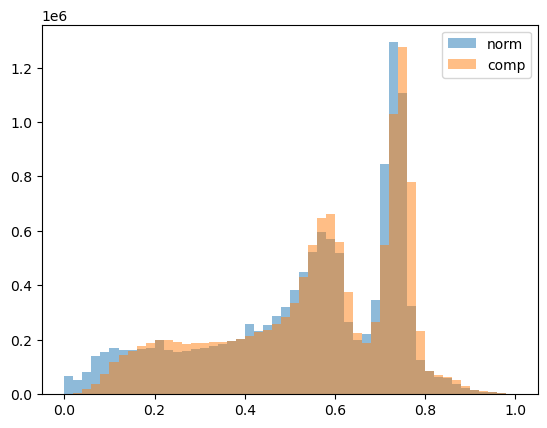

In [15]:

plt.hist(ciri_norm.flatten(), bins=50, alpha=0.5, label="norm");
plt.hist(ciri_comp.flatten(), bins=50, alpha=0.5, label="comp");
plt.legend();

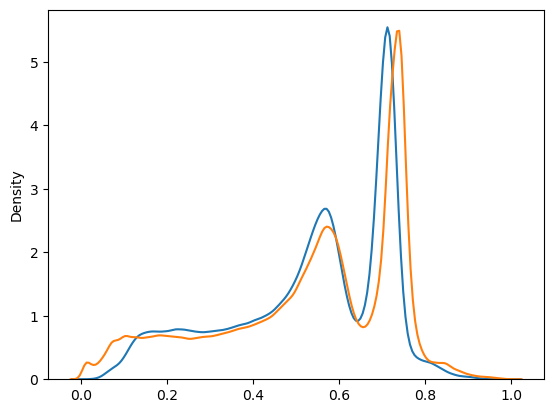

In [ ]:
sns.kdeplot(ciri_norm.flatten(), label="norm");
sns.kdeplot(ciri_comp.flatten(), label="comp");